# Custom Objective Function

pyPESTO can not only do parameter estimation for PEtab and AMICI models, but is able to do so on any provided function.
This is done by providing the objective with the function as well as possibly gradient and hessian.
In this notebook, we will show a few different ways on how to do this. As sometimes manually providing the gradient and hessian is tedious, we will try to emphasize on the importance of those two.

After this notebook, you should ...
* ... be able to create an objective from a given function.
* ... be able to potentially add a gradient and hessian to the objective.
* ... be able to run parameter estimation on the objective.
* ... know the importance of gradient and hessian in terms of optimization speed and accuracy.

In [1]:
# install if not done yet
# %pip install pypesto --quiet

In [2]:
import logging

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from IPython.display import Markdown, display

import pypesto
import pypesto.optimize as optimize
import pypesto.profile as profile
import pypesto.visualize as visualize

# set a random seed
np.random.seed(1912)

%matplotlib inline

## 1. Objective + Problem Definition

In the following we will use the Rosenbrock Banana function, which we can directly get from scipy.

The first creation of the objective function is rather straightforward:
We create it by providing a function, as well as gradient and hessian.

In [3]:
# first type of objective defined through callables
objective1 = pypesto.Objective(
    fun=sp.optimize.rosen,
    grad=sp.optimize.rosen_der,
    hess=sp.optimize.rosen_hess,
)

The second option is to provide a function that returns objective value, gradient and hessian (last two optional) all as a tuple.
In this case, we just need to notify the pyPESTO objective of this through boolean values.

In [4]:
# second type of objective
def rosen2(x):
    return (
        sp.optimize.rosen(x),
        sp.optimize.rosen_der(x),
        sp.optimize.rosen_hess(x),
    )


objective2 = pypesto.Objective(fun=rosen2, grad=True, hess=True)

For later comparisons, we create two other objectives. One that is only provided with function and gradient, and one that only has the functional value, forcing it to rely on finite differences in optimization.

In [5]:
# no hessian objective
objective3 = pypesto.Objective(
    fun=sp.optimize.rosen,
    grad=sp.optimize.rosen_der,
)

# neither hessian nor gradient objective
objective4 = pypesto.Objective(
    fun=sp.optimize.rosen,
)

To get from objective to a usable parameter estimation problem, we need to additionally provide the bounds of our parameters.

In [6]:
dim_full = 15
lb = -5 * np.ones((dim_full, 1))
ub = 5 * np.ones((dim_full, 1))

# for the sake of comparison, we create 100 starts within these bounds
x_guesses = np.random.uniform(-5, 5, (20, dim_full))

problem1 = pypesto.Problem(
    objective=objective1, lb=lb, ub=ub, x_guesses=x_guesses
)
problem2 = pypesto.Problem(
    objective=objective2, lb=lb, ub=ub, x_guesses=x_guesses
)
problem3 = pypesto.Problem(
    objective=objective3, lb=lb, ub=ub, x_guesses=x_guesses
)
problem4 = pypesto.Problem(
    objective=objective4, lb=lb, ub=ub, x_guesses=x_guesses
)

Some initial guesses supplied violate the bounds set for this problem.
Some initial guesses supplied violate the bounds set for this problem.
Some initial guesses supplied violate the bounds set for this problem.
Some initial guesses supplied violate the bounds set for this problem.


### Illustration

The Rosenbrock function is a function, which is often used to test optimization algorithms. It is defined as
$$
f(x) = \sum_{i=1}^{n-1} 100 (x_{i+1} - x_i^2)^2 + (1 - x_i)^2, \quad x \in \mathbb{R}^n
$$
This function has a global minimum at $x^* = (1, \dots, 1)$ with $f(x^*) = 0$. If $n\geq 4$, the function has an additional local minimum at $x^* = (-1, 1, \dots, 1)$ with $f(x^*) = 4$.

We will illustrate the function for $n=2$.

In [7]:
x = np.arange(-2, 2, 0.1)
y = np.arange(-2, 2, 0.1)
x, y = np.meshgrid(x, y)
z = np.zeros_like(x)
for j in range(0, x.shape[0]):
    for k in range(0, x.shape[1]):
        z[j, k] = objective1([x[j, k], y[j, k]], (0,))

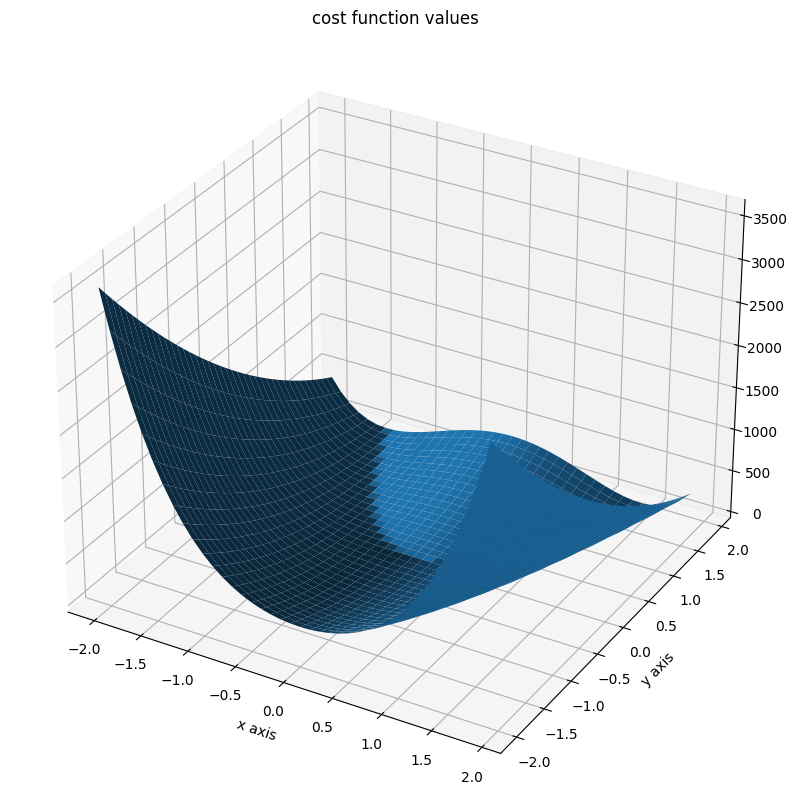

In [8]:
fig = plt.figure()
fig.set_size_inches(*(14, 10))
ax = plt.axes(projection="3d")
ax.plot_surface(X=x, Y=y, Z=z)
plt.xlabel("x axis")
plt.ylabel("y axis")
ax.set_title("cost function values");

And a contour plot:

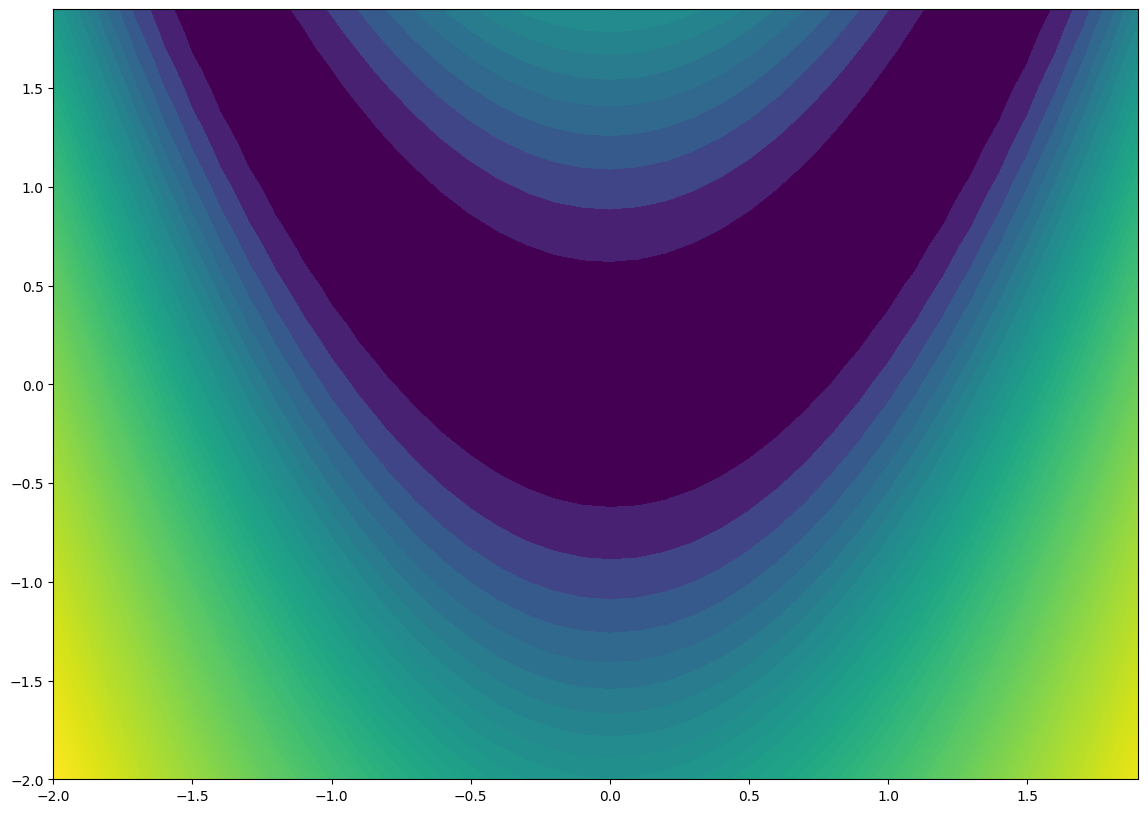

In [23]:
fig = plt.figure()
fig.set_size_inches(*(14, 10))
ax = plt.axes()
ax.contourf(x, y, z, 100, norm="log");

## 2. Optimization

In [24]:
# optimizer
optimizer = optimize.ScipyOptimizer()
# engine
engine = pypesto.engine.MultiProcessEngine()
# starts
n_starts = 20

Engine set up to use up to 8 processes in total. The number was automatically determined and might not be appropriate on some systems.


As a first comparison, we time each optimization. We also use the same optimizer and engine for all optimizations.

In [26]:
# run optimization of problem 1
result1 = optimize.minimize(
    problem=problem1, optimizer=optimizer, n_starts=n_starts, engine=engine
)
# run optimization of problem 2
result2 = optimize.minimize(
    problem=problem2, optimizer=optimizer, n_starts=n_starts, engine=engine
)
# run optimization of problem 3
result3 = optimize.minimize(
    problem=problem3, optimizer=optimizer, n_starts=n_starts, engine=engine
)
# run optimization of problem 4
result4 = optimize.minimize(
    problem=problem4, optimizer=optimizer, n_starts=n_starts, engine=engine
)

Performing parallel task execution on 8 processes.
100%|██████████| 20/20 [00:00<00:00, 127.02it/s]
Performing parallel task execution on 8 processes.
100%|██████████| 20/20 [00:04<00:00,  4.30it/s] 
Performing parallel task execution on 8 processes.
100%|██████████| 20/20 [00:00<00:00, 170.82it/s]
Performing parallel task execution on 8 processes.
100%|██████████| 20/20 [00:00<00:00, 202.26it/s]


As a first step, let us take a look at the different result summaries:

In [27]:
display(
    Markdown("# Result 1\n" + result1.optimize_result.summary(disp_best=False))
)
display(
    Markdown("# Result 2\n" + result2.optimize_result.summary(disp_best=False))
)
display(
    Markdown("# Result 3\n" + result3.optimize_result.summary(disp_best=False))
)
display(
    Markdown("# Result 4\n" + result4.optimize_result.summary(disp_best=False))
)

# Result 1
## Optimization Result 

* number of starts: 20 
* best value: 7.453730008169132e-11, id=3
* worst value: 3.986623815839845, id=4
* number of non-finite values: 0

* execution time summary:
	* Mean execution time: 0.039s
	* Maximum execution time: 0.049s,	id=11
	* Minimum execution time: 0.025s,	id=19
* summary of optimizer messages:

  |   Count | Message                                         |
  |--------:|:------------------------------------------------|
  |      20 | CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH |

* best value found (approximately) 15 time(s)
* number of plateaus found: 2


# Result 2
## Optimization Result 

* number of starts: 20 
* best value: 7.453730008169132e-11, id=3
* worst value: 3.986623815839845, id=4
* number of non-finite values: 0

* execution time summary:
	* Mean execution time: 0.048s
	* Maximum execution time: 0.068s,	id=7
	* Minimum execution time: 0.036s,	id=19
* summary of optimizer messages:

  |   Count | Message                                         |
  |--------:|:------------------------------------------------|
  |      20 | CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH |

* best value found (approximately) 15 time(s)
* number of plateaus found: 2


# Result 3
## Optimization Result 

* number of starts: 20 
* best value: 7.453730008169132e-11, id=3
* worst value: 3.986623815839845, id=4
* number of non-finite values: 0

* execution time summary:
	* Mean execution time: 0.039s
	* Maximum execution time: 0.050s,	id=7
	* Minimum execution time: 0.022s,	id=5
* summary of optimizer messages:

  |   Count | Message                                         |
  |--------:|:------------------------------------------------|
  |      20 | CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH |

* best value found (approximately) 15 time(s)
* number of plateaus found: 2


# Result 4
## Optimization Result 

* number of starts: 20 
* best value: 0.10824257960966652, id=9
* worst value: 9.838560189421912, id=11
* number of non-finite values: 0

* execution time summary:
	* Mean execution time: 0.162s
	* Maximum execution time: 0.183s,	id=0
	* Minimum execution time: 0.100s,	id=19
* summary of optimizer messages:

  |   Count | Message                                              |
  |--------:|:-----------------------------------------------------|
  |      20 | STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT |

* best value found (approximately) 1 time(s)
* number of plateaus found: 4


Here we can see already a big difference between the first three and the fourth. The one without gradients took approximately five times as long to finish the optimization as the other three. The best value found ist also not the same as for the others. But the biggest difference is probably the fact that while the first three all converged in all their starts, the one without gradient reach the maximum number of evaluations in most to all cases. Keep in mind: **All starts were the same for all problems**.

A small detail here:
When comparing the first three results, one may notice two things. For one, leaving out the hessian seems not make any difference. And additionally, while they are rather close in speed compared to the fourth one, the second one sticks out to be somewhat slower.
This is mainly due to the fact that we chose the scipy optimizer "l-bfgs-b", which does not support the usage of a hessian, for the sake of comparing all four of them. This also explains why the second one is slower, as (by construction), whether needed or not, problem2 will evaluate the hessian.

### Visualization

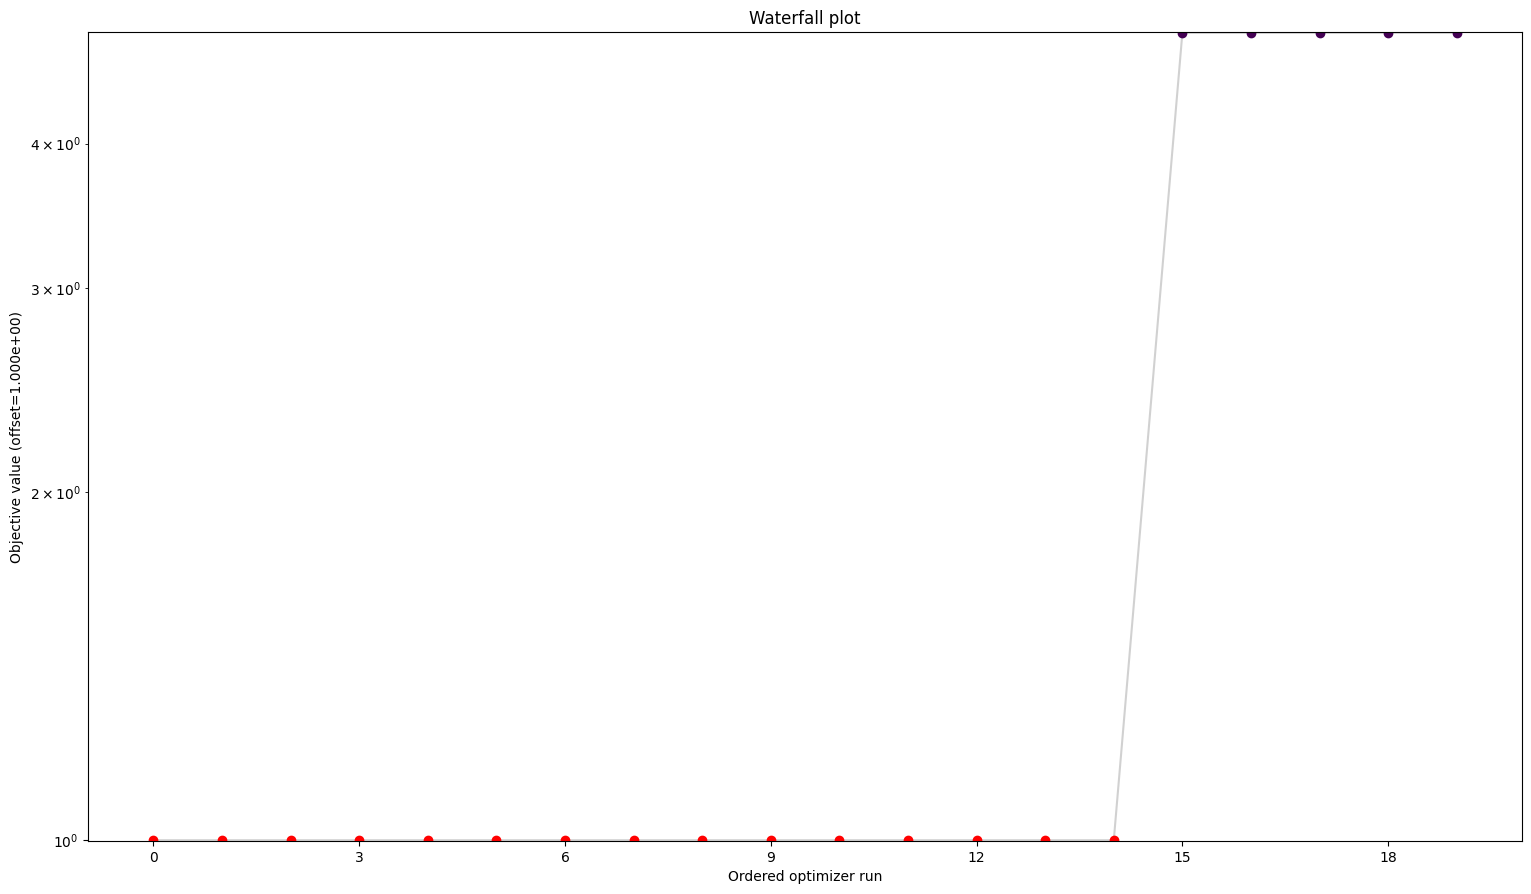

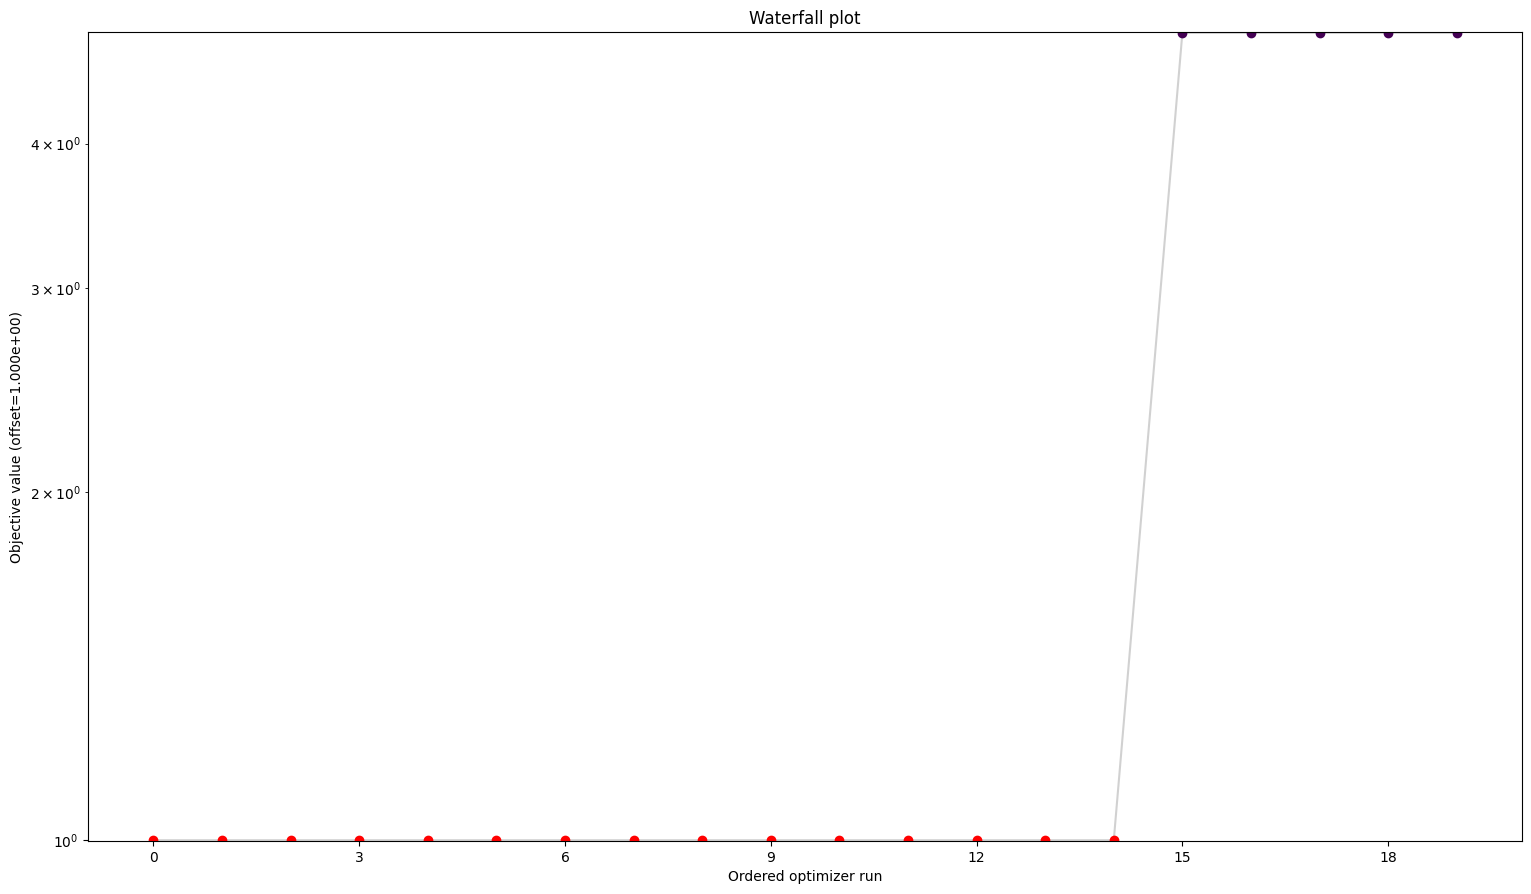

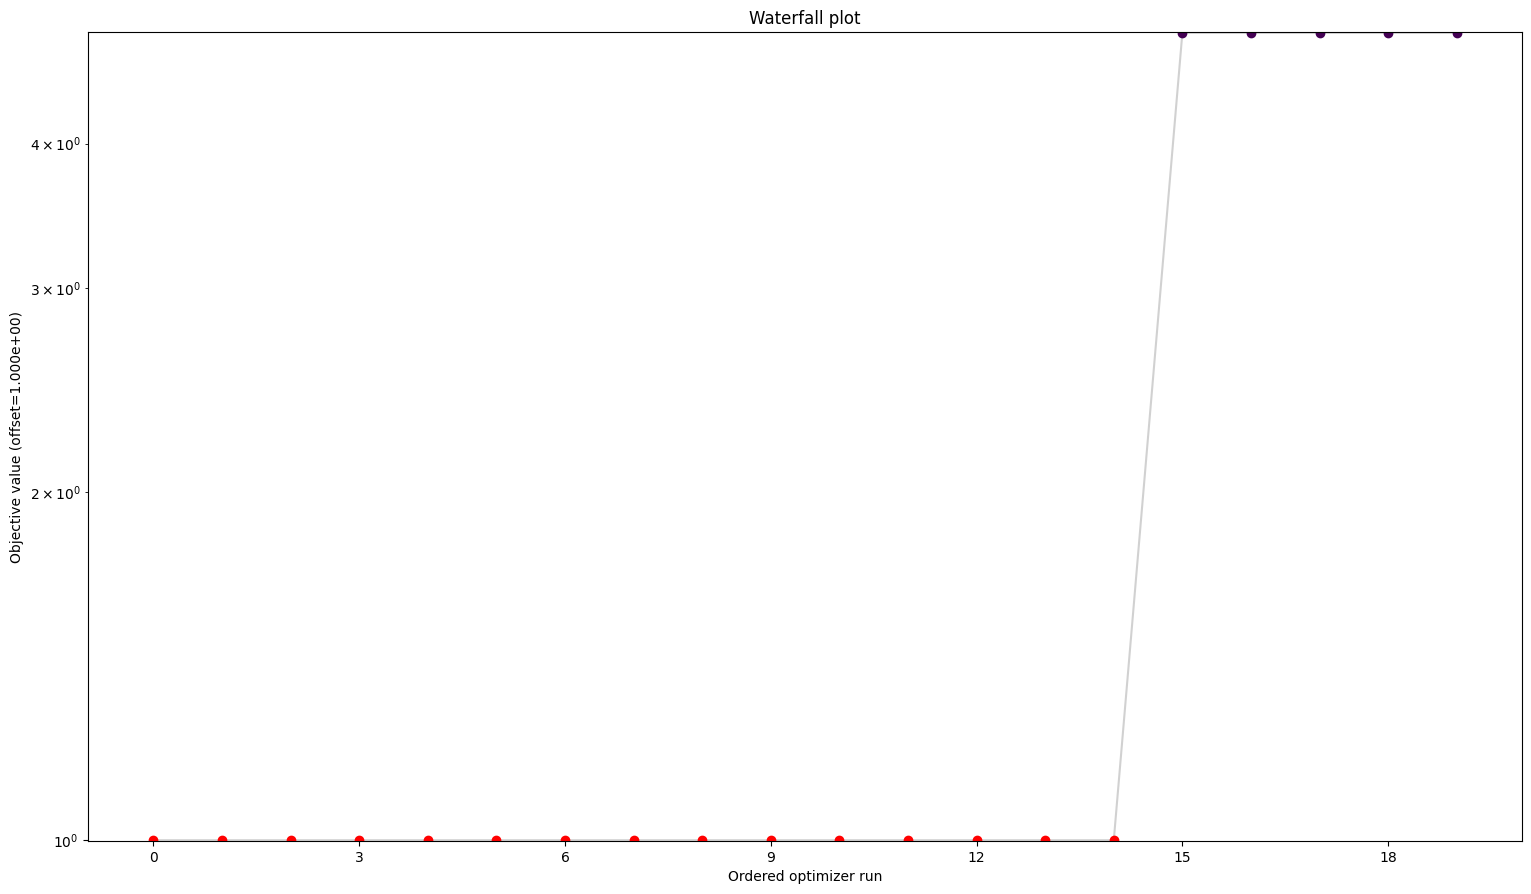

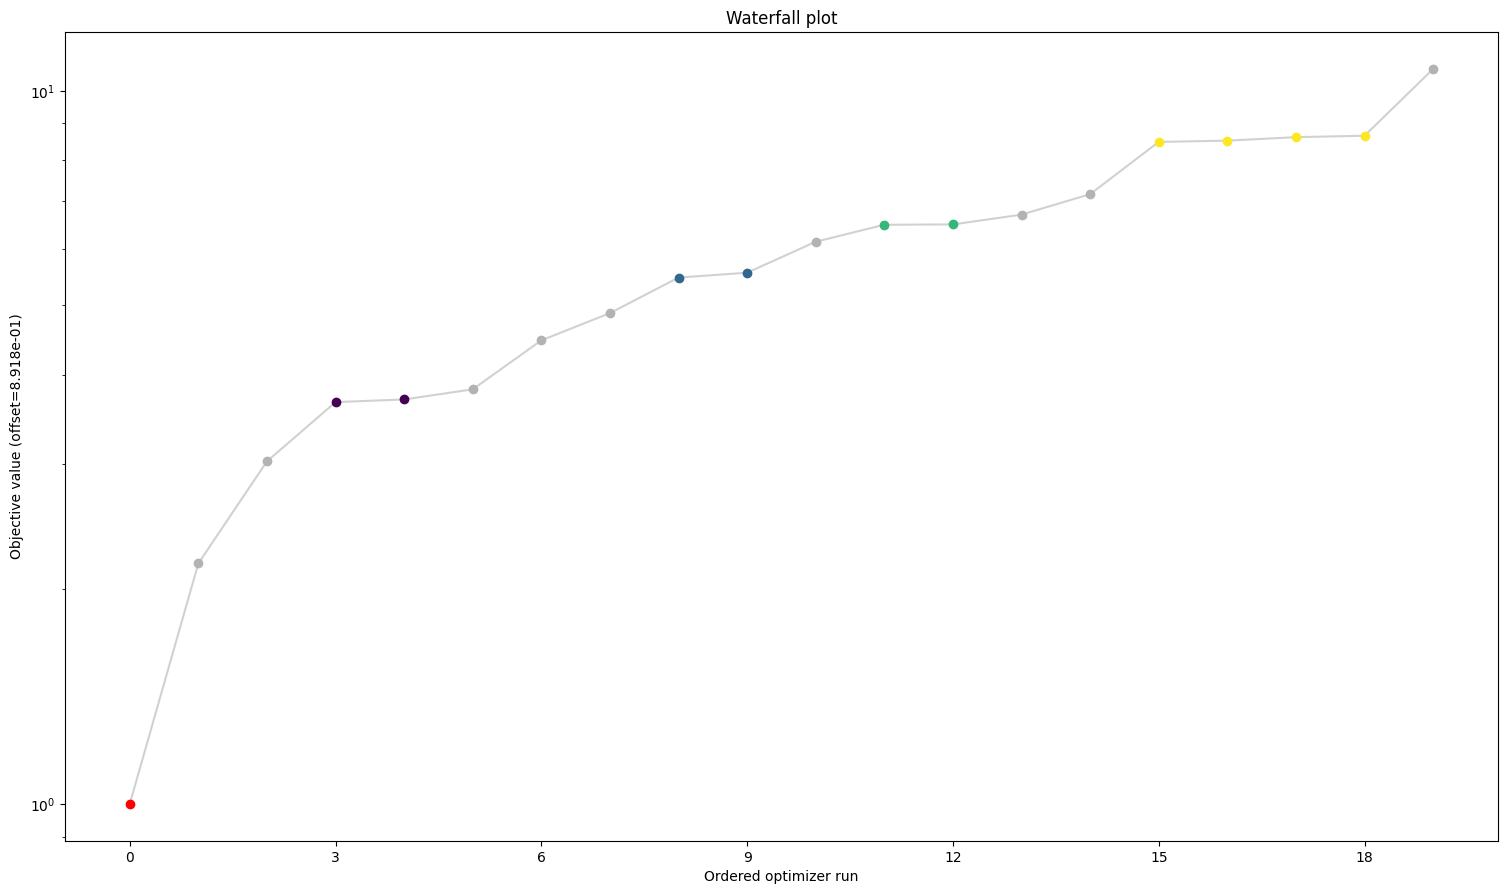

In [28]:
# waterfalls
visualize.waterfall(result1)
visualize.waterfall(result2)
visualize.waterfall(result3)
visualize.waterfall(result4);

We can see here already the stark difference between the problem definitions. In order to compare things easier, we can also plot all results in one waterfall plot:

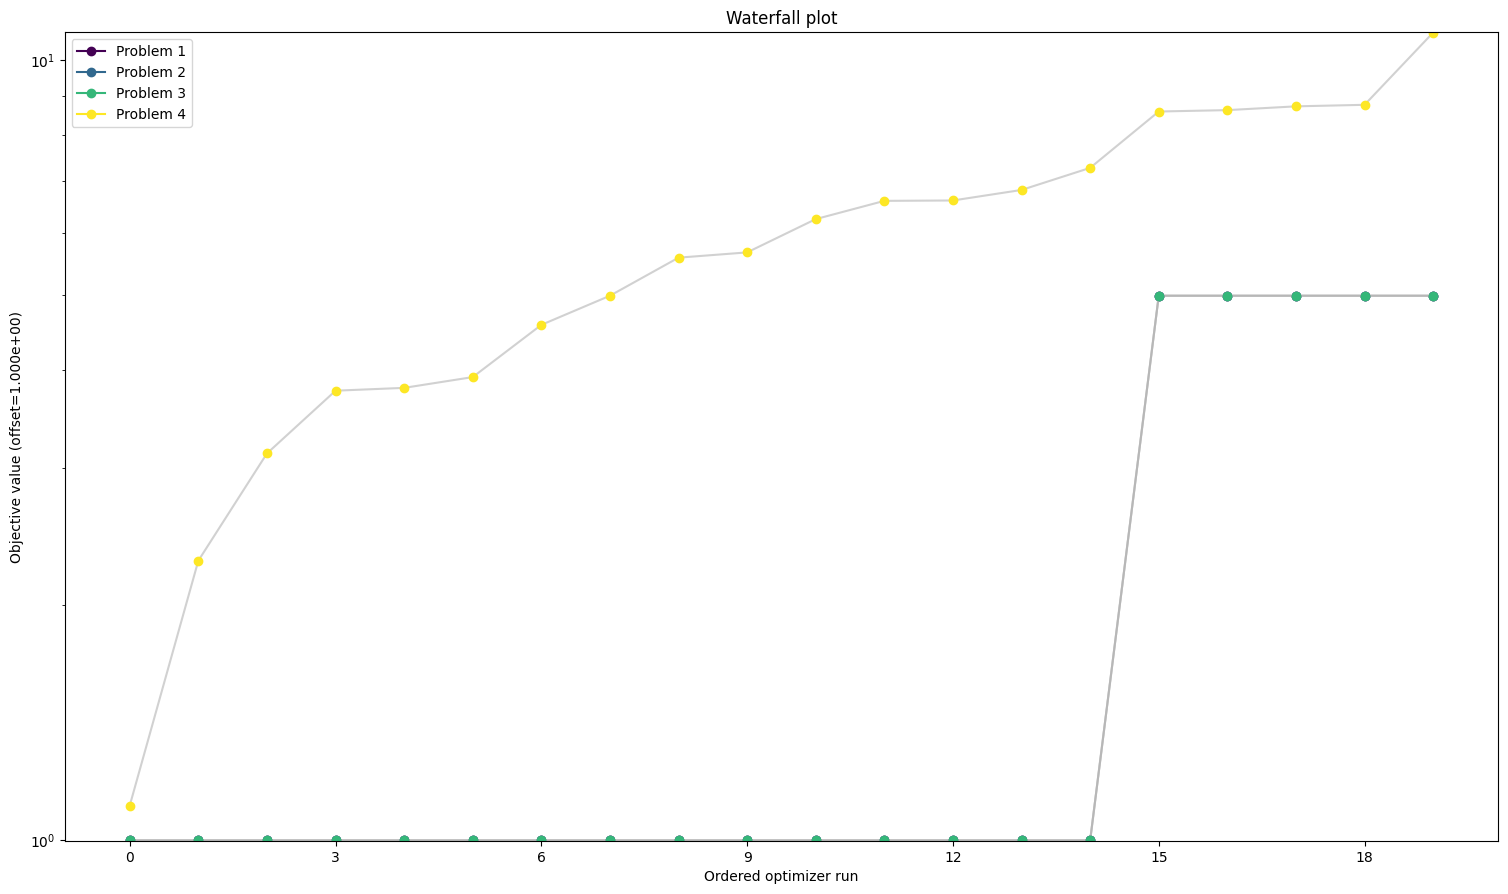

In [29]:
# plot one list of waterfalls
visualize.waterfall(
    [result1, result2, result3, result4],
    legends=["Problem 1", "Problem 2", "Problem 3", "Problem 4"],
);

We can also take a look at the parameters, that each optimizer found:

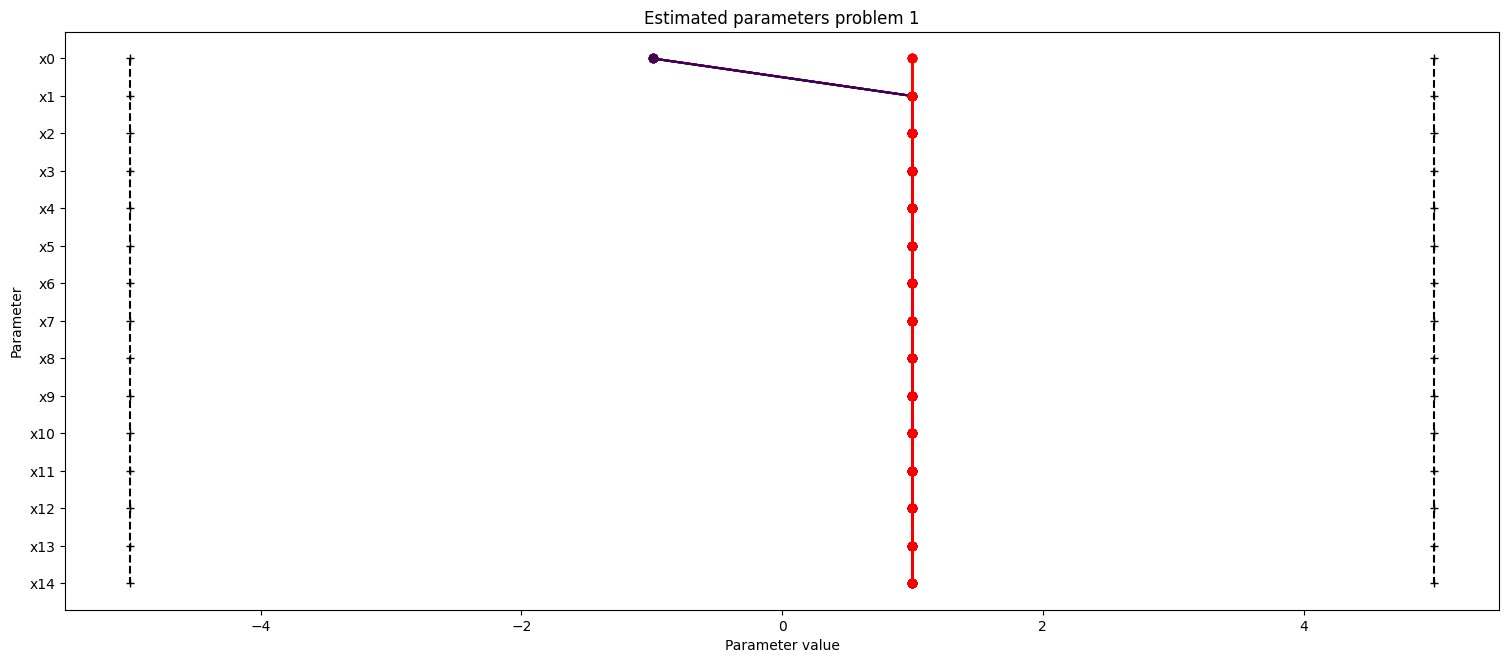

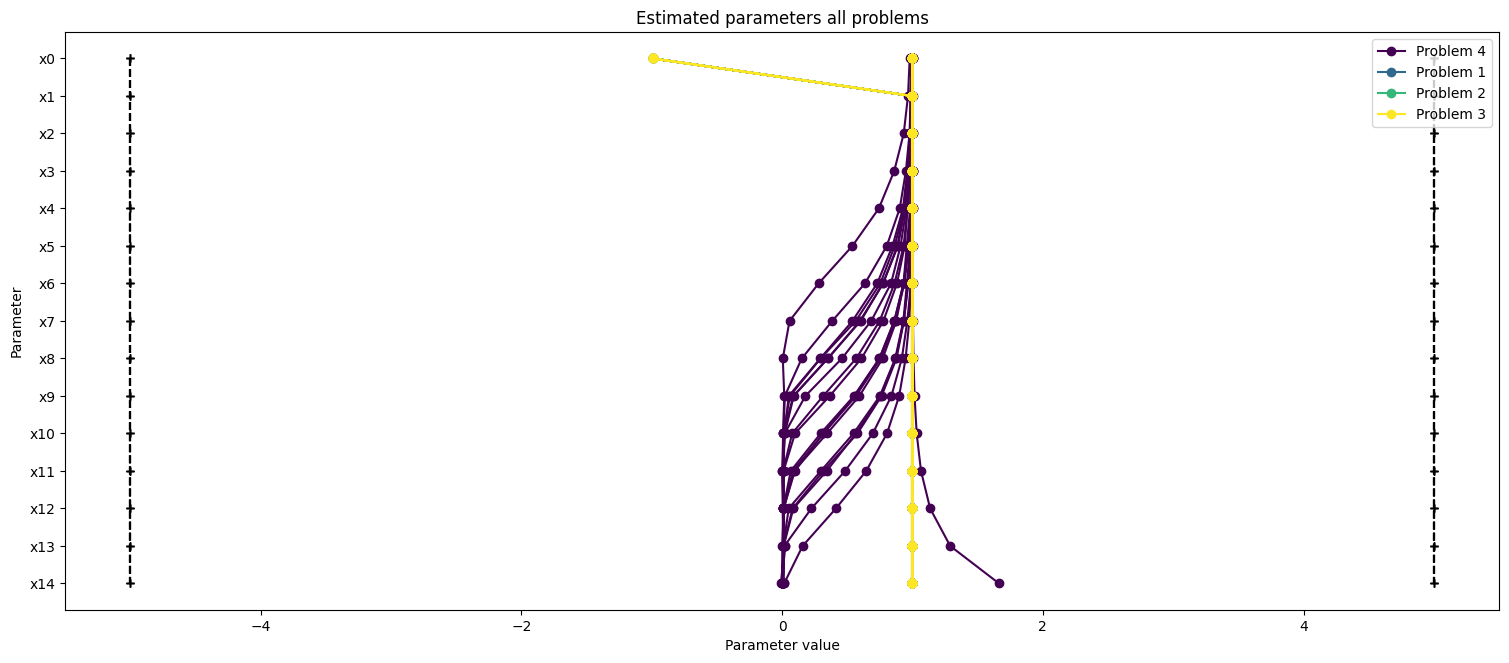

In [30]:
# plot parameters
ax = visualize.parameters(
    result1,
)
ax.set_title("Estimated parameters problem 1")
ax2 = visualize.parameters(
    [result4, result1, result2, result3],
    legends=["Problem 4", "Problem 1", "Problem 2", "Problem 3"],
)
ax2.set_title("Estimated parameters all problems");

## 3. Profiling

We want to create profiles for our parameters to know more about their uncertainties. We shall create profiles for problem 1 and 4. For problem 1 specifically, we create two profiles, as we have seen, that there are two distinct optima, so we want to start our profile likelihood from both optima.

Note that when running profiles, the cost function is interpreted as a negative log likelihood function. This has some implications on the stopping criteria of the algorithm and on the confidence intervals. Therefore a meaningful statistical interpretation of the results is only possible if the cost function is a negative log likelihood function or a negative log posterior function. The same holds for sampling.

In [31]:
# we create references for each "best point":
ref = {
    "x": result1.optimize_result.x[0],
    "fval": result1.optimize_result.fval[0],
    "color": [0.2, 0.4, 1.0, 1.0],
    "legend": "First optimum problem 1",
}
ref = visualize.create_references(ref)[0]
# we create references for each "best point":
ref2 = {
    "x": result1.optimize_result.x[-1],
    "fval": result1.optimize_result.fval[-1],
    "color": [0.4, 1.0, 0.2, 1.0],
    "legend": "Second optimum problem 1",
}
ref2 = visualize.create_references(ref2)[0]
# we create references for each "best point":
ref4 = {
    "x": result4.optimize_result.x[0],
    "fval": result4.optimize_result.fval[0],
    "color": [0.2, 0.4, 1.0, 1.0],
    "legend": "First optimum problem 4",
}
ref4 = visualize.create_references(ref4)[0];

In [32]:
# compute profiles
profile_options = profile.ProfileOptions(whole_path=True)

result1 = profile.parameter_profile(
    problem=problem1,
    result=result1,
    optimizer=optimizer,
    profile_index=np.array([0, 1, 3, 5]),
    result_index=0,
    profile_options=profile_options,
    filename=None,
)

# compute profiles from second optimum
result1 = profile.parameter_profile(
    problem=problem1,
    result=result1,
    optimizer=optimizer,
    profile_index=np.array([0, 1, 3, 5]),
    result_index=-1,
    profile_options=profile_options,
    filename=None,
)
result4 = profile.parameter_profile(
    problem=problem4,
    result=result4,
    optimizer=optimizer,
    profile_index=np.array([0, 1, 3, 5]),
    result_index=0,
    profile_options=profile_options,
    filename=None,
)

100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


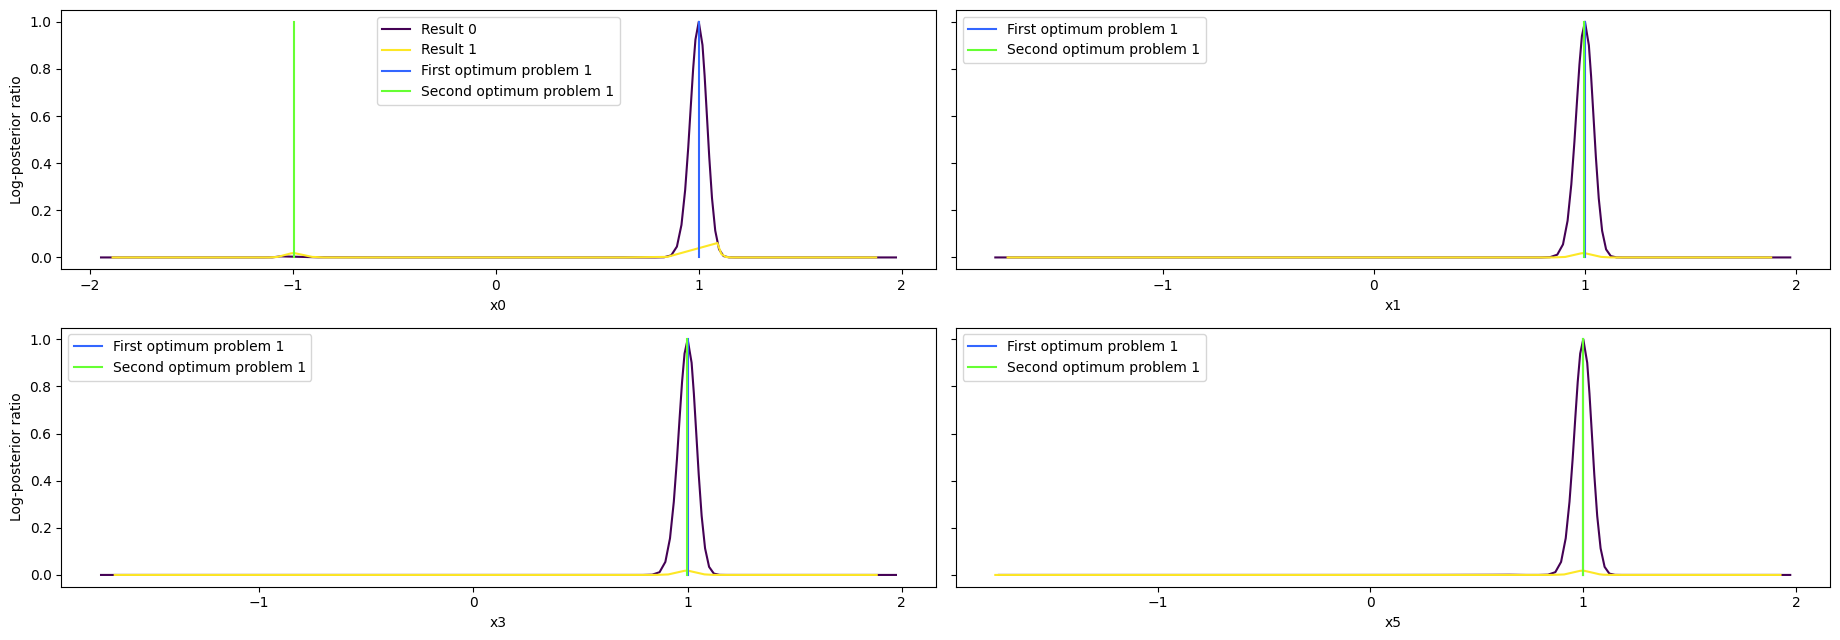

In [33]:
# specify the parameters, for which profiles should be computed
visualize.profiles(
    result1,
    profile_indices=[0, 1, 3, 5],
    reference=[ref, ref2],
    profile_list_ids=[0, 1],
);

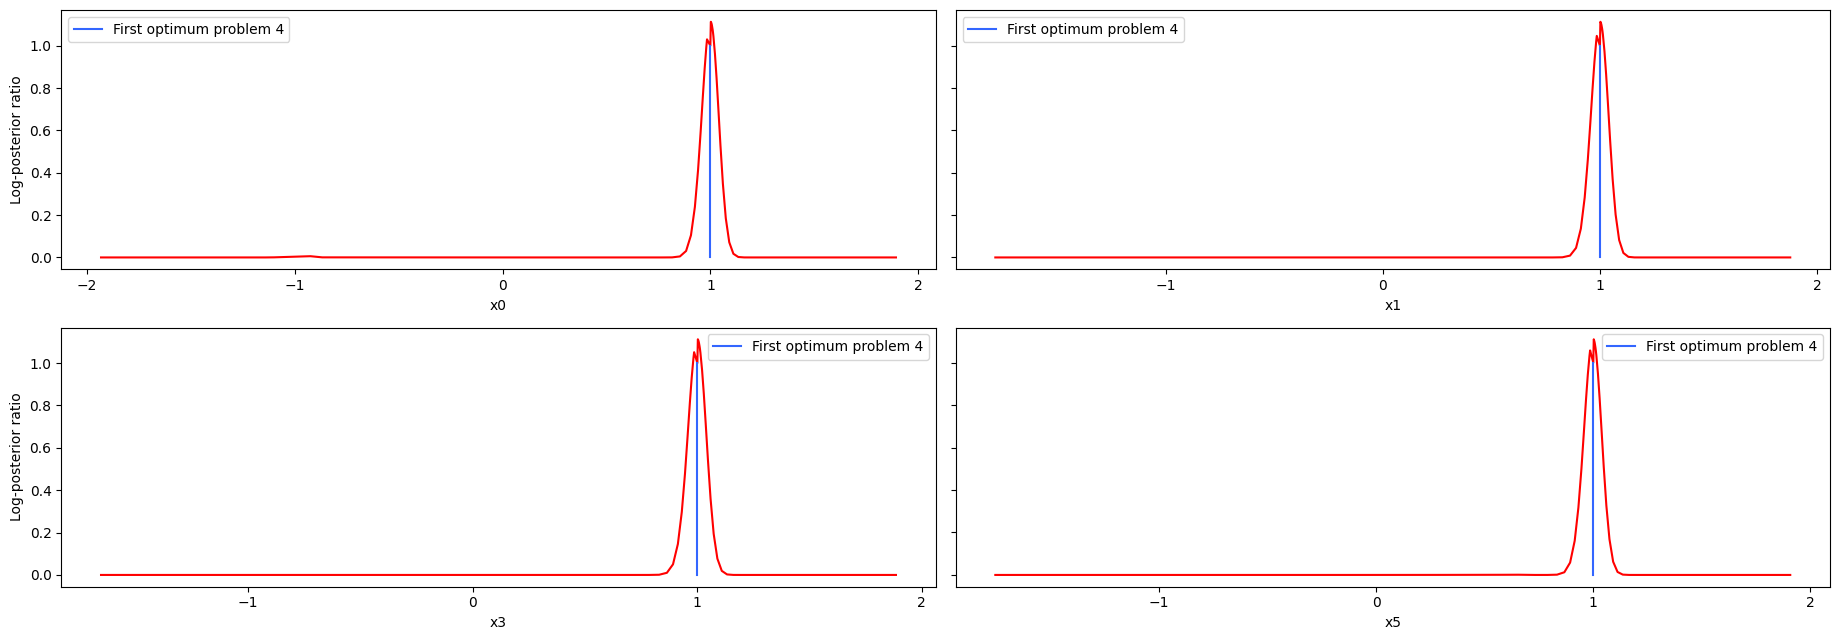

In [34]:
visualize.profiles(
    result4,
    profile_indices=[0, 1, 3, 5],
    reference=[ref4],
);

As we can see here, the second optimum disagrees only in the very first value. Here it becomes apparent that it is only a local optimum, as the profile for the second optimum is very flat. Comparing the profiles of proplem 1 and 4, we can see, that while the convergence of problem4 was quite bad, the profiles look really similar.

### Profile approximation

When computing the profiles is computationally too demanding, it is possible to employ to at least consider a normal approximation with covariance matrix given by the Hessian or FIM at the optimal parameters.

In [35]:
result1 = profile.approximate_parameter_profile(
    problem=problem1,
    result=result1,
    profile_index=np.array([0, 1, 3, 5]),
    result_index=0,
    n_steps=1000,
)

Computing Hessian/FIM as not available in result.


These approximate profiles require at most one additional function evaluation, can however yield substantial approximation errors:

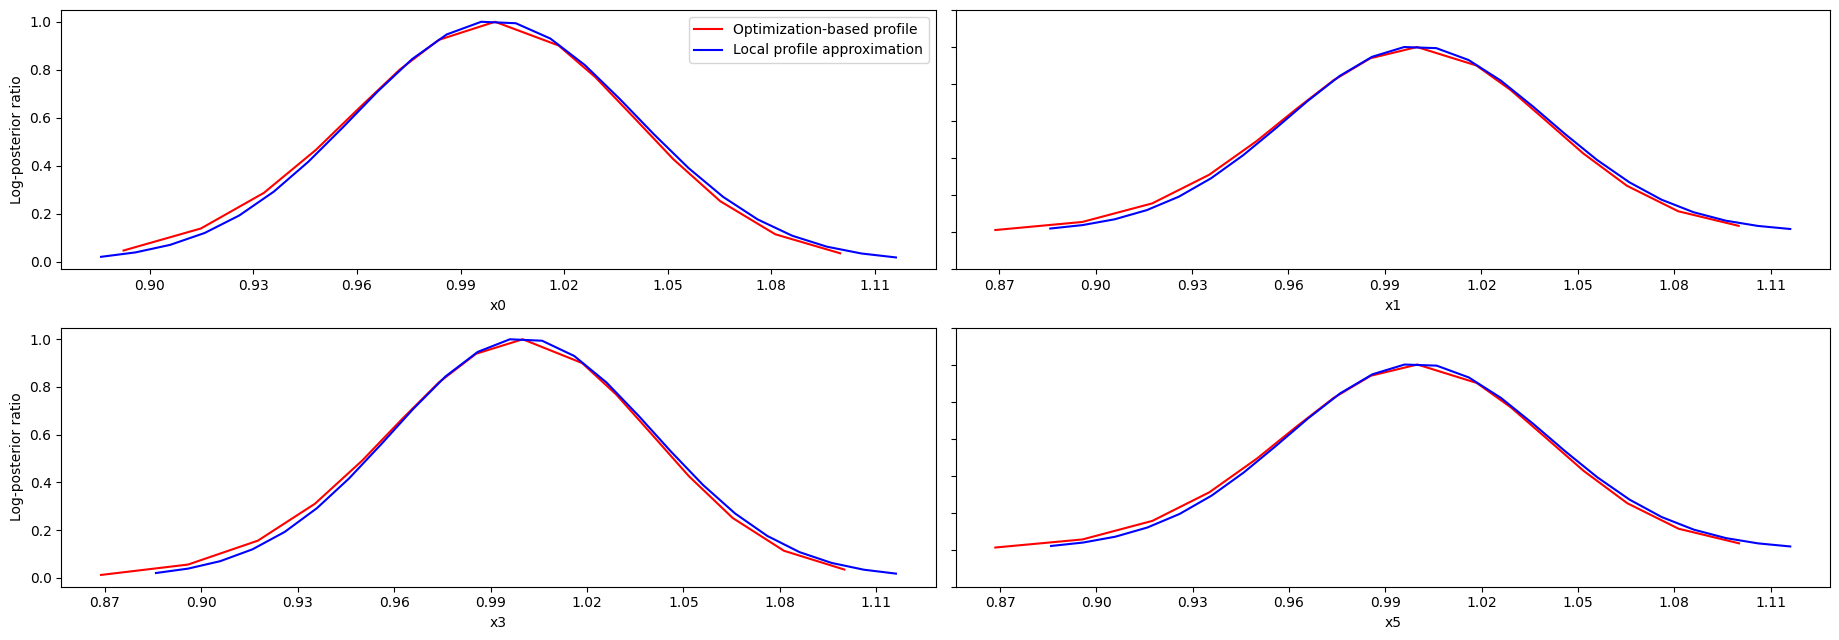

In [36]:
axes = visualize.profiles(
    result1,
    profile_indices=[0, 1, 3, 5],
    profile_list_ids=[0, 2],
    ratio_min=0.01,
    colors=[(1, 0, 0, 1), (0, 0, 1, 1)],
    legends=[
        "Optimization-based profile",
        "Local profile approximation",
    ],
);

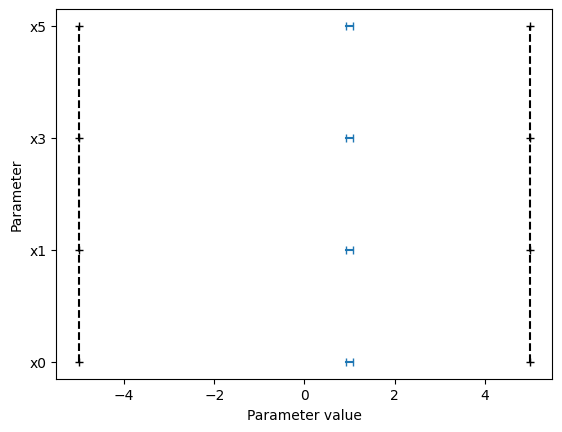

In [37]:
visualize.profile_cis(
    result1, confidence_level=0.95, profile_list=2, show_bounds=True
);